References: https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/object_detection_using_vision_transformer.ipynb

https://keras.io/examples/vision/image_classification_with_vision_transformer/

Author: Anjali Murali

Date Created: 11/06/2023

Date last modified: 12/06/2023

In [ ]:
import numpy as np
import tensorflow as tf
#dataset
import zipfile
import os
import PIL
import PIL.Image
import tensorflow_datasets as tfds
#end of dataset

In [ ]:
!pip install -U tensorflow-addons

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

#Dataset


In [ ]:
import pathlib
dataset_url = "file:///content/FMD_extended.zip"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)

In [ ]:
archive

'/root/.keras/datasets/FMD_extended.zip'

In [ ]:
os.path.getsize(archive)

144810508

In [ ]:
with zipfile.ZipFile(archive,"r") as zip_ref:
    zip_ref.extractall("targetdir")

In [ ]:
data_dir = pathlib.Path('/content/targetdir/FMD_extended/')

In [ ]:
data_dir

PosixPath('/content/targetdir/FMD_extended')

In [ ]:
os.path.getsize(data_dir)

4096

In [ ]:
for item in data_dir.glob("*"):
  print(item.name)

mask
image


In [ ]:
image_count = len(list(data_dir.glob('image/fabric/*.jpg')))
print(image_count)

146


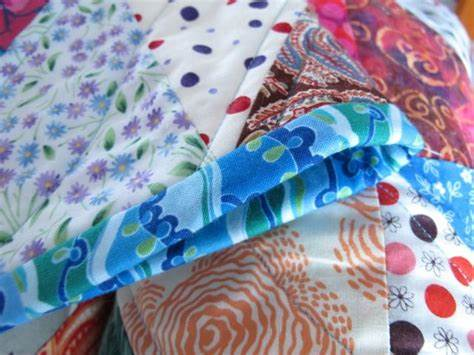

In [ ]:
fabric = list(data_dir.glob('image/fabric/*'))
PIL.Image.open(str(fabric[0]))

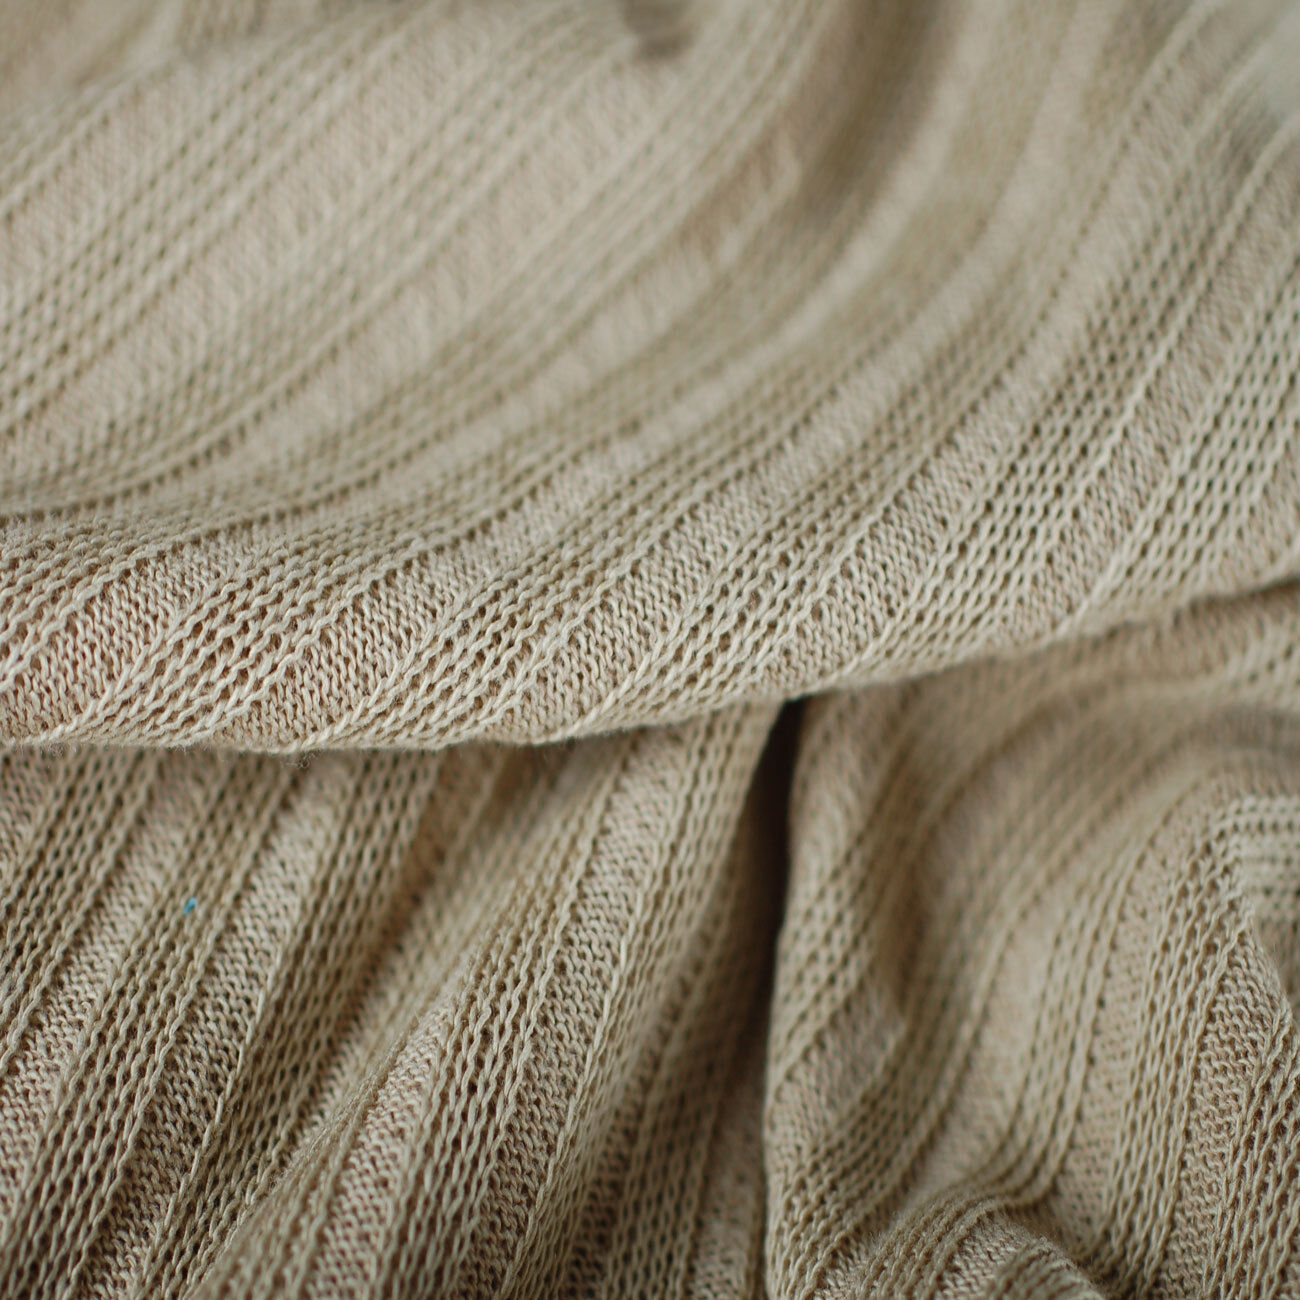

In [ ]:
PIL.Image.open(str(fabric[1]))

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
images = data_dir / 'image'
images

PosixPath('/content/targetdir/FMD_extended/image')

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  images,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1474 files belonging to 10 classes.
Using 1180 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  images,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1474 files belonging to 10 classes.
Using 294 files for validation.


In [ ]:
x_train = []
y_train = []

for images, labels in train_ds:
    x_train.extend(images.numpy())
    y_train.extend(labels.numpy())

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train)

[[[[236.       232.       255.      ]
   [236.       232.       255.      ]
   [236.       232.       255.      ]
   ...
   [236.       232.       255.      ]
   [236.       232.       255.      ]
   [236.       232.       255.      ]]

  [[236.       232.       255.      ]
   [236.       232.       255.      ]
   [236.       232.       255.      ]
   ...
   [236.       232.       255.      ]
   [236.       232.       255.      ]
   [236.       232.       255.      ]]

  [[236.       232.       255.      ]
   [236.       232.       255.      ]
   [236.       232.       255.      ]
   ...
   [236.       232.       255.      ]
   [236.       232.       255.      ]
   [236.       232.       255.      ]]

  ...

  [[101.81667  131.37029   43.498096]
   [126.2666   141.69984   55.833164]
   [148.57384  148.00894   78.90711 ]
   ...
   [154.28593  166.37845   97.99893 ]
   [111.882645 114.48813   53.67706 ]
   [163.3292   160.39403   91.37735 ]]

  [[135.87799  156.7557    74.1335  ]
   [138

In [ ]:
len(x_train)

1180

In [ ]:
print(y_train)

[5 9 8 ... 8 4 1]


In [ ]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'fabric', 'food', 'glass', 'leather', 'metal', 'paper', 'plastic', 'stone', 'wood']


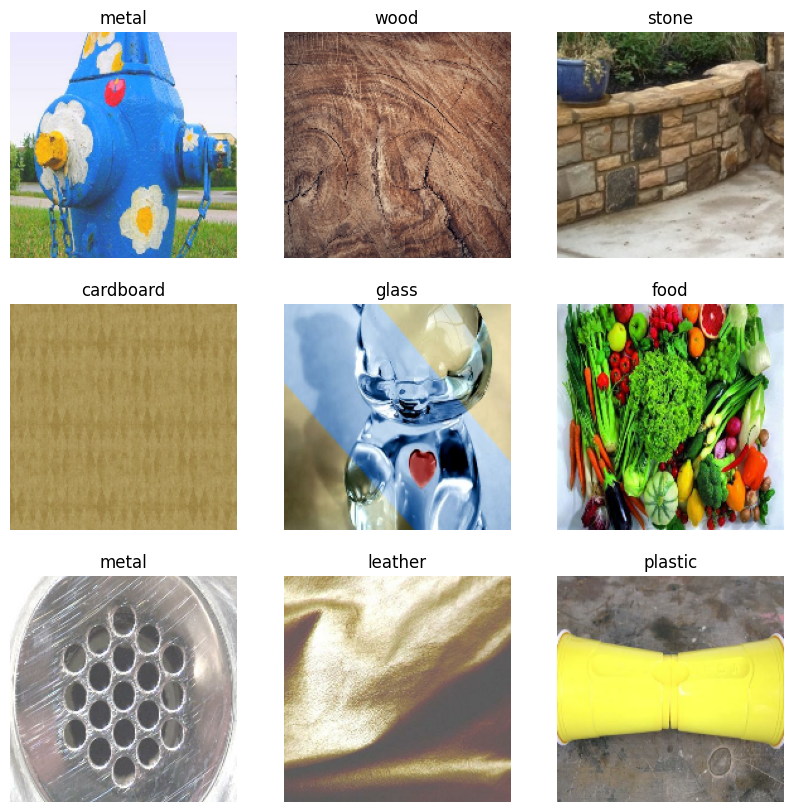

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(x_train[i].astype("uint8"))
  plt.title(class_names[y_train[i]])
  plt.axis("off")

plt.show()

In [ ]:
x_test = []
y_test = []

for images, labels in val_ds:
    x_test.extend(images.numpy())
    y_test.extend(labels.numpy())

x_test = np.array(x_test)
y_test = np.array(y_test)
# print(x_test)

#Vision Transformer

In [ ]:
num_classes = len(class_names)
print(num_classes)
input_shape = (180, 180, 3)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

10
x_train shape: (1180, 180, 180, 3) - y_train shape: (1180,)
x_test shape: (294, 180, 180, 3) - y_test shape: (294,)


In [ ]:
learning_rate = 0.01
weight_decay = 0.0001
batch_size = 128
num_epochs = 100
image_size = 224
patch_size = 32
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 8
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 32
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)


In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 224 X 224
Patch size: 32 X 32
Patches per image: 49
Elements per patch: 3072


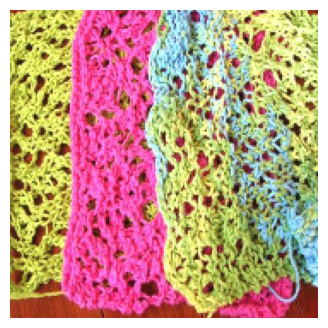

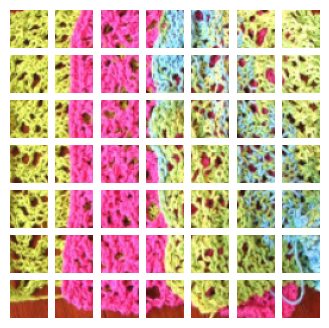

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=0.001)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)


        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.25)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)
    # Classify outputs.
    logits = layers.Dense(num_classes, activation = tf.nn.softmax)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
import math
def lr_decay(epoch):
  return 0.01 * math.pow(0.5, epoch)
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

#Compile, train, and evaluate the model

In [ ]:
def run_experiment(model):
    optimizer = tf.keras.optimizers.Adam(learning_rate =0.001)


    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_test,y_test),
        callbacks=[checkpoint_callback, lr_decay_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/100
10/10 [==============================] - 125s 1s/step - loss: 60.8939 - accuracy: 0.0924 - top-5-accuracy: 0.5661 - val_loss: 3.5570 - val_accuracy: 0.1156 - val_top-5-accuracy: 0.5170 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.005.
Epoch 2/100
10/10 [==============================] - 8s 845ms/step - loss: 3.2044 - accuracy: 0.1237 - top-5-accuracy: 0.5458 - val_loss: 2.3487 - val_accuracy: 0.1735 - val_top-5-accuracy: 0.5578 - lr: 0.0050

Epoch 3: LearningRateScheduler setting learning rate to 0.0025.
Epoch 3/100
10/10 [==============================] - 6s 594ms/step - loss: 2.3615 - accuracy: 0.1500 - top-5-accuracy: 0.5873 - val_loss: 2.2406 - val_accuracy: 0.1871 - val_top-5-accuracy: 0.6020 - lr: 0.0025

Epoch 4: LearningRateScheduler setting learning rate to 0.00125.
Epoch 4/100
10/10 [==============================] - 7s 678ms/step - loss: 2.2760 - accuracy: 0.1907 - top-5-acc

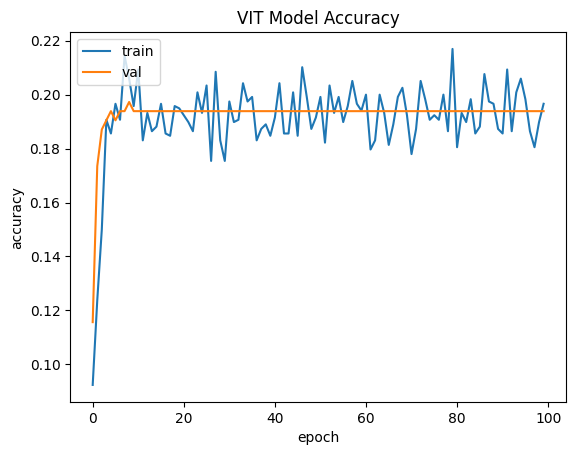

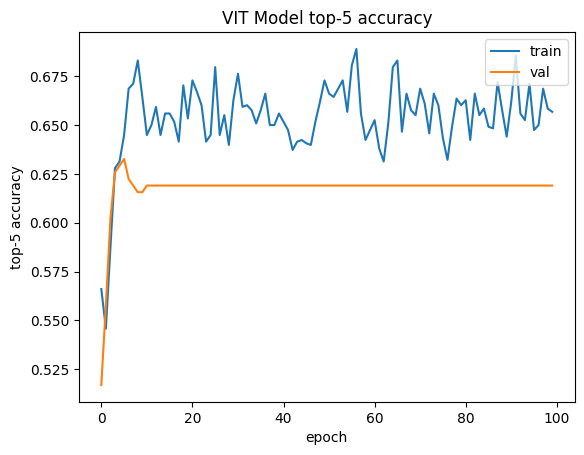

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VIT Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['top-5-accuracy'])
plt.plot(history.history['val_top-5-accuracy'])
plt.title('VIT Model top-5 accuracy')
plt.ylabel('top-5 accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.988059 to fit



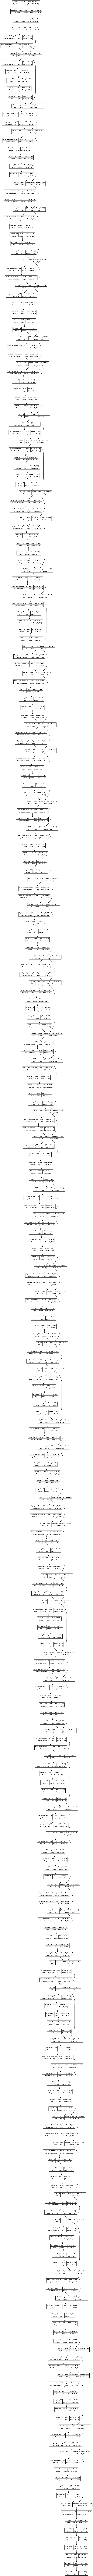

In [ ]:
vit_img_file = '/tmp/vit_model.png'
tf.keras.utils.plot_model(vit_classifier, to_file=vit_img_file, show_shapes=True,
                          show_layer_activations=False, show_trainable=False)

In [ ]:
predictions = vit_classifier.predict(x_test[:10])
print(predictions)

1/1 [==============================] - 6s 6s/step
[[0.05749355 0.14039569 0.03674909 0.0997087  0.06798893 0.12984386
  0.18370298 0.1001825  0.10200315 0.08193156]
 [0.06085901 0.13120058 0.04536659 0.11244552 0.07426465 0.12029784
  0.18604574 0.09165088 0.10531659 0.0725526 ]
 [0.05051243 0.13761692 0.04095207 0.10599186 0.07850637 0.10393005
  0.1970108  0.0912194  0.11226211 0.08199809]
 [0.10344886 0.06424615 0.25420296 0.15471664 0.1414127  0.04024091
  0.10186614 0.06821503 0.03374762 0.03790304]
 [0.07223728 0.11639083 0.05554905 0.09679964 0.08136273 0.12377553
  0.14600468 0.0974773  0.120364   0.09003894]
 [0.08631297 0.06957885 0.23714624 0.06540413 0.09707554 0.10533878
  0.07713296 0.09029063 0.06753298 0.10418685]
 [0.05880206 0.16430216 0.05333032 0.09632474 0.1114542  0.10189652
  0.12342776 0.08851286 0.1119609  0.08998844]
 [0.06210345 0.12064479 0.05400634 0.10410331 0.08470548 0.10480834
  0.16538112 0.09778966 0.11443209 0.09202545]
 [0.1341326  0.07435333 0.1734

In [ ]:
print(np.argmax(predictions, axis=1))

[6 6 6 2 6 2 1 6 2 6]


In [ ]:
print(y_test[:10])

[6 6 8 3 1 7 8 6 2 2]
